We can actually use our interval estimates to approximate all manner of Hardware properties such as:

* On CPU time of operations (e.g. some reads are slower than others)
* Request size distributions (e.g. some reads are bigger than others)
* Disk latency (e.g. some disks are faster or more consistent than others)

For a concrete example let's model a m5d drive which we [model](https://github.com/Netflix-Skunkworks/service-capacity-modeling/blob/dd1fb503b4505327d1cf14d2d614c0e796bb8f05/service_capacity_modeling/hardware/profiles/shapes/aws.json#L98) with an io latency distribution. Data for comparision comes from using `biosnoop` and [`histogram.py`](https://github.com/bitly/data_hacks/blob/master/data_hacks/histogram.py) on a Cassandra server (the threads that are servicing reads are from the SharedPool).

```bash
$ sudo /usr/share/bcc/tools/biosnoop > ios
$ grep SharedPool ios | tr -s ' ' | cut -f 8  -d ' ' > io_lat
$ cat io_lat | histogram.py -l -p
# NumSamples = 107517; Min = 0.06; Max = 2.43
# Mean = 0.118898; Variance = 0.002304; SD = 0.048005; Median 0.100000
# each ∎ represents a count of 569
    0.0600 -     0.0623 [    94]:  (0.09%)
    0.0623 -     0.0670 [     0]:  (0.00%)
    0.0670 -     0.0762 [   505]:  (0.47%)
    0.0762 -     0.0948 [ 33459]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (31.12%)
    0.0948 -     0.1318 [ 42706]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (39.72%)
    0.1318 -     0.2060 [ 29154]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (27.12%)
    0.2060 -     0.3542 [   994]: ∎ (0.92%)
    0.3542 -     0.6508 [   523]:  (0.49%)
    0.6508 -     1.2438 [    77]:  (0.07%)
    1.2438 -     2.4300 [     5]:  (0.00%)
```

In [1]:
from service_capacity_modeling.stats import dist_for_interval
from service_capacity_modeling.interface import FixedInterval, Interval

import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
data = {}
for io_data in glob.glob("io_latency/*"):
    real_data = np.loadtxt(io_data)
    real_interval = np.percentile(real_data, [5, 50, 95])

    read_io_latency = FixedInterval(
        minimum_value=min(real_data),
        low=round(real_interval[0], 2),
        mid=round(np.mean(real_data), 4),
        high=round(real_interval[2], 2),
        maximum_value=max(real_data),
        confidence=0.9
    )

    io_beta = dist_for_interval(read_io_latency)
    print(f"\nAnalyzing {io_data}")
    print(f"{real_interval} with mean {np.mean(real_data)} and range [{min(real_data)}, {max(real_data)}]")
    print(read_io_latency.json(exclude_unset=True))
    data[io_data] = {}
    data[io_data]["real"] = real_data
    data[io_data]["interval"] = read_io_latency.json(exclude_unset=True)
    data[io_data]["dist"] = io_beta


Analyzing io_latency/m5d_cass_io_lat
[0.08 0.1  0.18] with mean 0.11889756968665424 and range [0.06, 2.43]
{"low": 0.08, "mid": 0.1189, "high": 0.18, "confidence": 0.9, "minimum_value": 0.06, "maximum_value": 2.43}

Analyzing io_latency/i4i_cass_io_lat
[0.1  0.13 0.17] with mean 0.13218869181915266 and range [0.02, 2.05]
{"low": 0.1, "mid": 0.1322, "high": 0.17, "confidence": 0.9, "minimum_value": 0.02, "maximum_value": 2.05}

Analyzing io_latency/gp2_cass_io_lat
[0.559 1.01  1.611] with mean 1.0578129117259552 and range [0.31, 7.88]
{"low": 0.56, "mid": 1.0578, "high": 1.61, "confidence": 0.9, "minimum_value": 0.31, "maximum_value": 7.88}

Analyzing io_latency/i3_cass_io_lat
[0.11 0.16 0.21] with mean 0.17415579742736348 and range [0.07, 4.18]
{"low": 0.11, "mid": 0.1742, "high": 0.21, "confidence": 0.9, "minimum_value": 0.07, "maximum_value": 4.18}


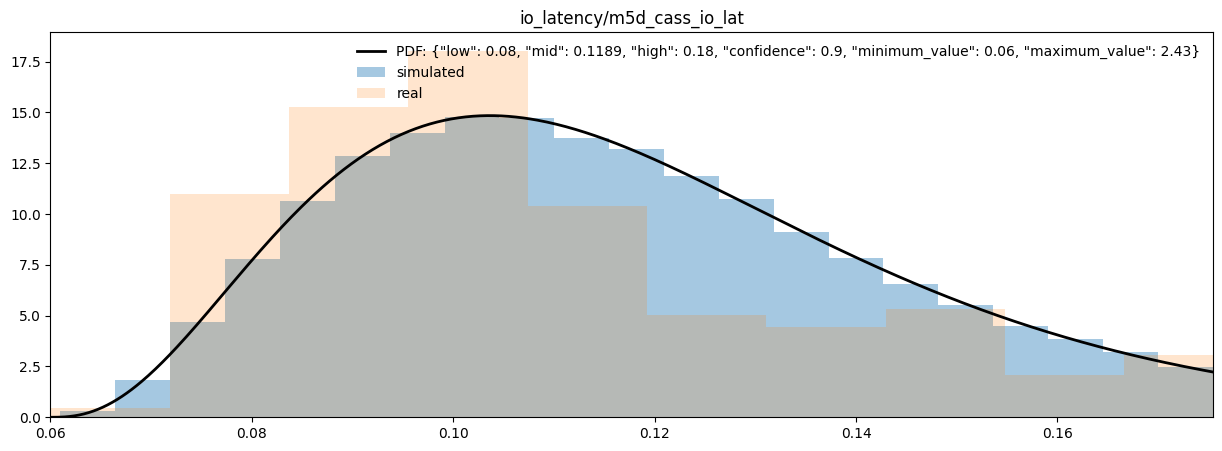

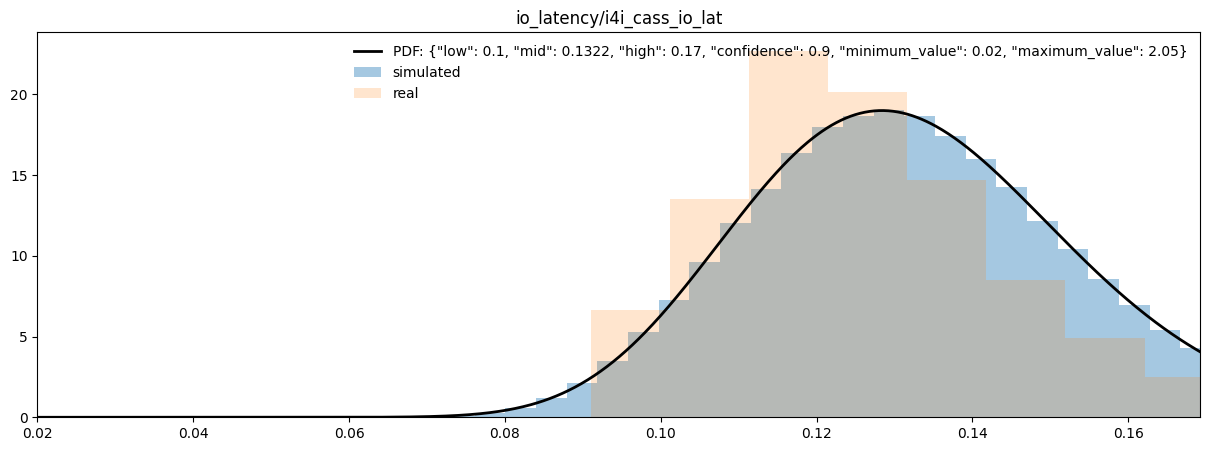

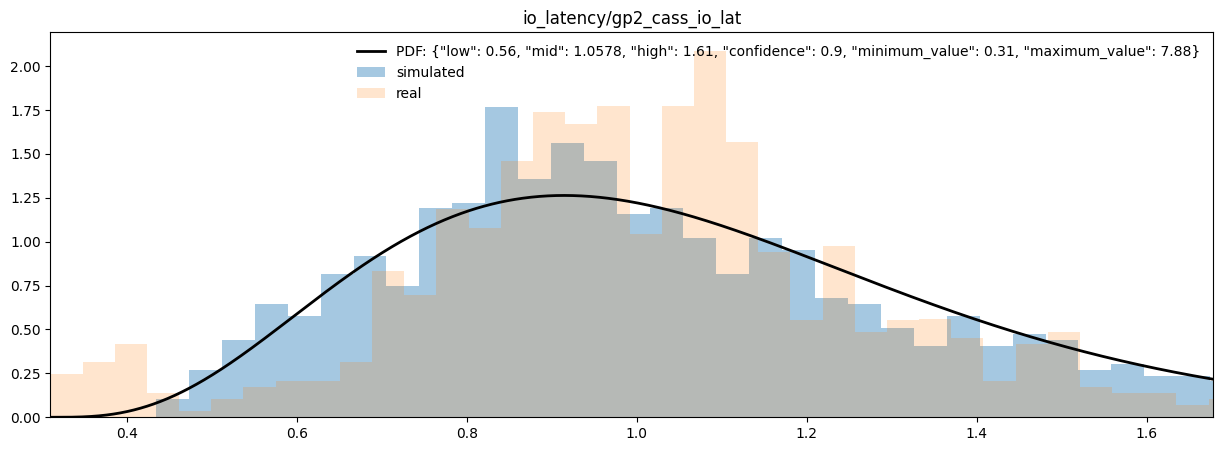

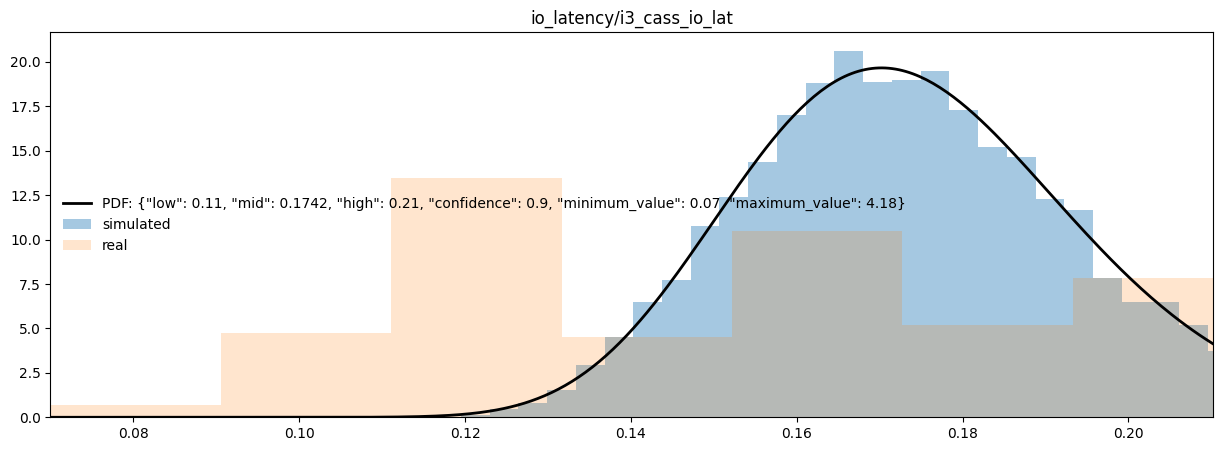

In [3]:
for sample in data:
    io_beta = data[sample]["dist"]
    real_data = data[sample]["real"]
    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    x = np.linspace(min(real_data), max(real_data), 10000)

    ax.plot(x, io_beta.pdf(x), 'k-', lw=2, label=f"PDF: {data[sample]['interval']}")

    r = io_beta.rvs(size=len(real_data))
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=50, label="simulated")
    ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

    ax.legend(loc='best', frameon=False)
    ax.set_title(sample)
    ax.set_xlim(min(real_data), io_beta.ppf(0.95))

    plt.show()

In [4]:
from scipy.stats import kstest
for sample in data:
    io_beta = data[sample]["dist"]
    real_data = data[sample]["real"]
    r = io_beta.rvs(size=len(real_data))
    print(sample, ":", kstest(r, real_data))

io_latency/m5d_cass_io_lat : KstestResult(statistic=0.23420482342327253, pvalue=0.0)
io_latency/i4i_cass_io_lat : KstestResult(statistic=0.1586108055593471, pvalue=0.0)
io_latency/gp2_cass_io_lat : KstestResult(statistic=0.10540184453227931, pvalue=0.0004311305222927429)
io_latency/i3_cass_io_lat : KstestResult(statistic=0.4208869299271386, pvalue=0.0)


# Adjustments
There are some odd bi-modalities going on here, so to compensate we can shift low and high around for our actual
hardware model to better fit the data.

io_latency/gp2_cass_io_lat : KstestResult(statistic=0.06982872200263504, pvalue=0.04937257310586834)


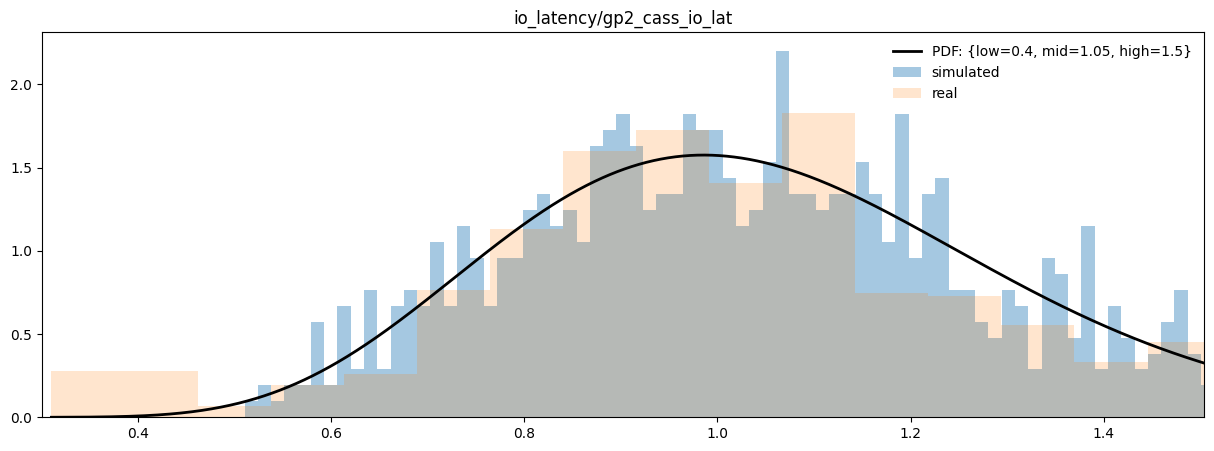

In [5]:
sample = "io_latency/gp2_cass_io_lat"

io_gamma = dist_for_interval(FixedInterval(minimim_value=0.2, low=0.4, mid=1.05, high=1.5, maximum_value=5, confidence=0.90))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label="PDF: {low=0.4, mid=1.05, high=1.5}")

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=100, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.3, io_gamma.ppf(0.95))

r = io_gamma.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

0.11889756968665424
io_latency/m5d_cass_io_lat : KstestResult(statistic=0.18122715477552387, pvalue=0.0)


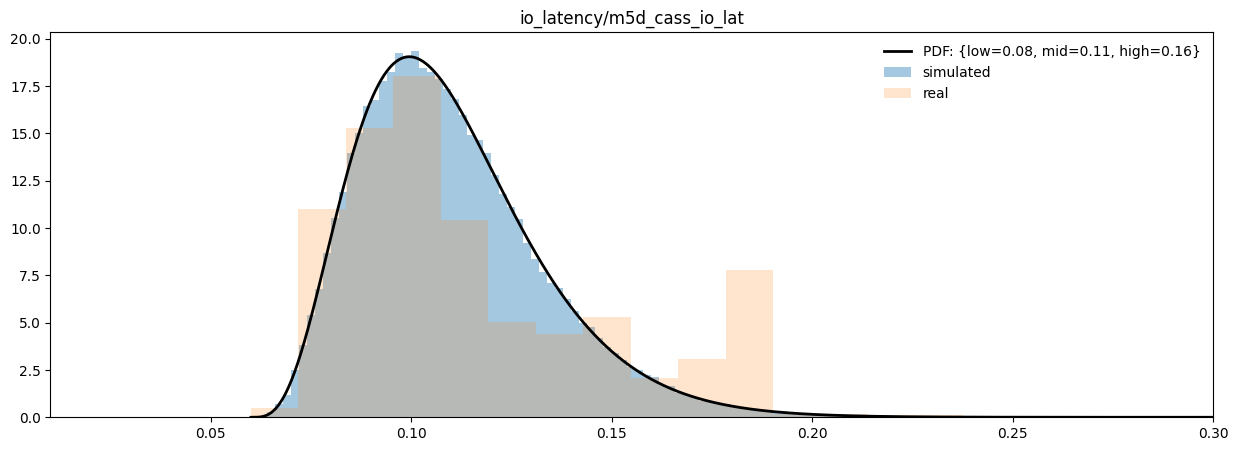

In [6]:
sample = "io_latency/m5d_cass_io_lat"

io_beta = dist_for_interval(FixedInterval(minimum_value=0.06, low=0.08, mid=0.11, high=0.16, maximum_value=4, confidence=0.90))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_beta.pdf(x), 'k-', lw=2, label="PDF: {low=0.08, mid=0.11, high=0.16}")

r = io_beta.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.01, 0.3)
print(np.mean(real_data))

r = io_beta.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

0.17415579742736348
io_latency/i3_cass_io_lat : KstestResult(statistic=0.13133039489070797, pvalue=4.774014972894231e-84)


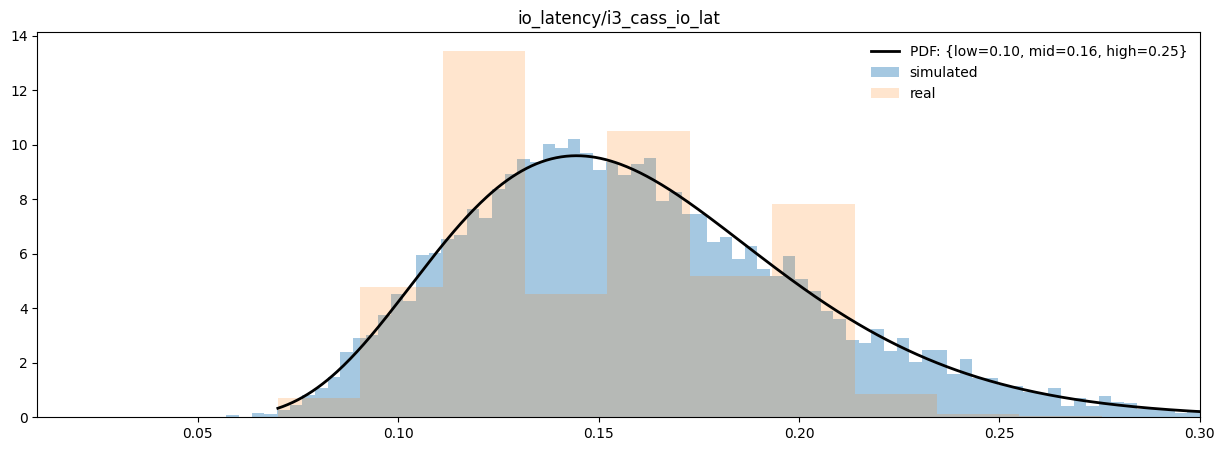

In [7]:
sample = "io_latency/i3_cass_io_lat"

io_beta = dist_for_interval(FixedInterval(minimum_value=0.04, low=0.10, mid=0.16, high=0.25, maximum_value=3, confidence=0.9))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_beta.pdf(x), 'k-', lw=2, label="PDF: {low=0.10, mid=0.16, high=0.25}")

r = io_beta.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.01, 0.3)
print(np.mean(real_data))

r = io_beta.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

0.13218869181915266
io_latency/i4i_cass_io_lat : KstestResult(statistic=0.20952331248444364, pvalue=0.0)


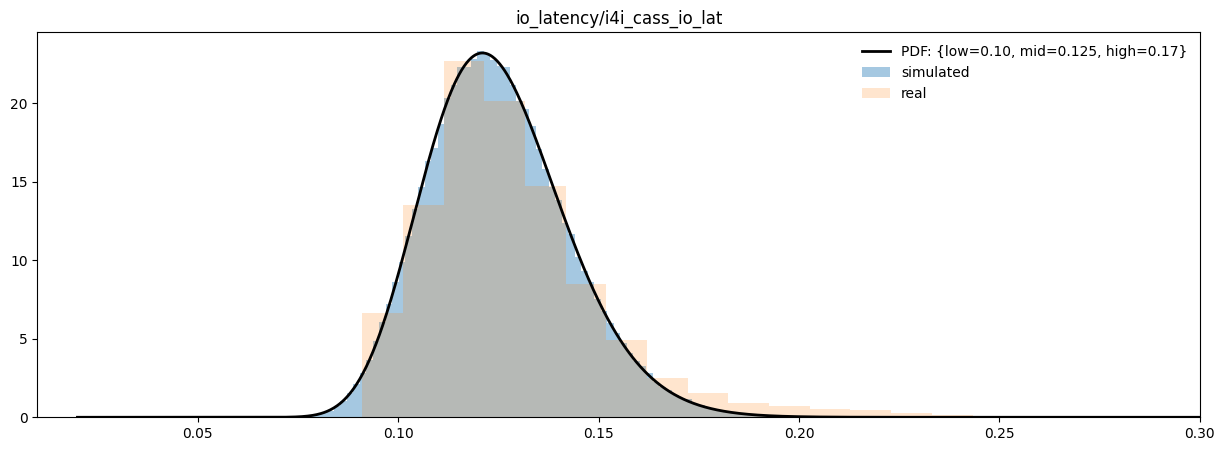

In [8]:
sample = "io_latency/i4i_cass_io_lat"

# Data says
# [0.1  0.13 0.17] with mean 0.13218869181915266 and range [0.02, 2.05]
# {"low": 0.1, "mid": 0.1322, "high": 0.17, "confidence": 0.9, "minimum_value": 0.02, "maximum_value": 2.05}

io_beta = dist_for_interval(FixedInterval(minimum_value=0.05, low=0.10, mid=0.125, high=0.17, maximum_value=2.05, confidence=0.9))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_beta.pdf(x), 'k-', lw=2, label="PDF: {low=0.10, mid=0.125, high=0.17}")

r = io_beta.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.01, 0.3)
print(np.mean(real_data))

r = io_beta.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

# Using Latency to Estimate Working Set

Now that we have distributions characterizing drive latency, we can set SLOs for different workloads (e.g. cache workloads or DB workloads) and then calculate how much of the SLO can be met by the drives. In cases where drives can't possibly meet our SLO, we have to provision RAM to compensate. 

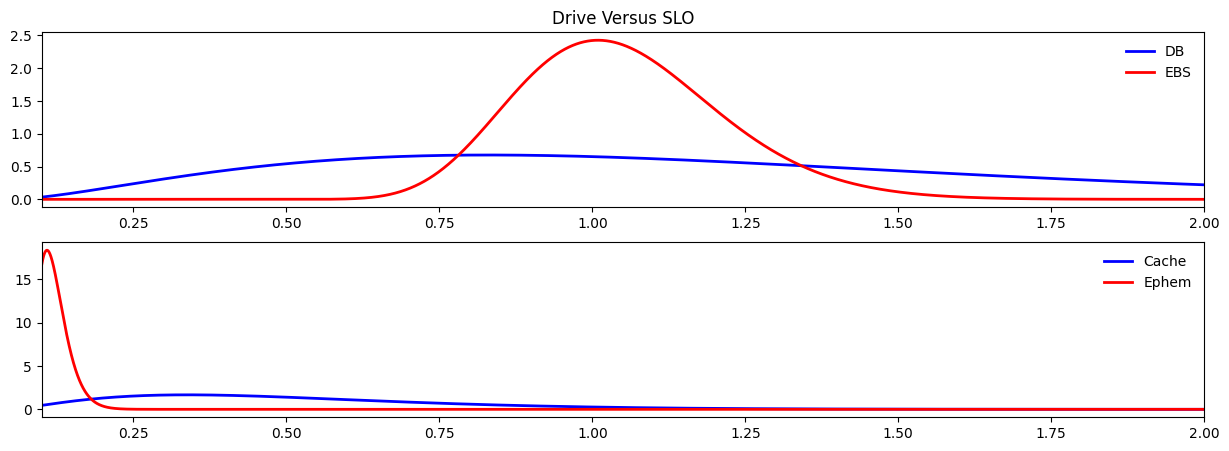

In [9]:
cache_slo = FixedInterval(minimum_value=0.05, low=0.1, mid=0.5, high=2, confidence=0.98)
db_slo = FixedInterval(minimum_value=0.05, low=0.2, mid=1.2, high=5, confidence=0.98)

ebs_latency = FixedInterval(low=0.8, mid=1.05, high=1.8, maximum_value=10, confidence=0.9)
ephem_latency = FixedInterval(minimum_value=0.07, low=0.08, mid=0.12, high=0.16, maximum_value=2, confidence=0.9)

cache_beta = dist_for_interval(cache_slo)
db_beta = dist_for_interval(db_slo)
ebs_beta = dist_for_interval(ebs_latency)
ephem_beta = dist_for_interval(ephem_latency)


fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15,5))

x = np.linspace(0.1, 2, 10000)

ax.plot(x, db_beta.pdf(x), 'b-', lw=2, label="DB")
ax.plot(x, ebs_beta.pdf(x), 'r-', lw=2, label="EBS")

ax2.plot(x, cache_beta.pdf(x), 'b-', lw=2, label="Cache")
ax2.plot(x, ephem_beta.pdf(x), 'r-', lw=2, label="Ephem")

ax.legend(loc='best', frameon=False)
ax.set_title("Drive Versus SLO")
ax.set_xlim(0.1, 2)
ax2.legend(loc='best', frameon=False)
ax2.set_xlim(0.1, 2)

plt.show()

In [10]:
target = 0.95
print(f"Target: {target}")
print(f"EBS latency (ms) at target: {ebs_beta.ppf(target)}")
print(f"Ephem latency (ms) at target: {ephem_beta.ppf(target)}")
print()
print(f"DB + EBS: {db_beta.cdf(ebs_beta.ppf(target))}")
print(f"DB + Ephem: {db_beta.cdf(ephem_beta.ppf(target))}")
print(f"Cache + EBS: {cache_beta.cdf(ebs_beta.ppf(target))}")
print(f"Cache + Ephem: {cache_beta.cdf(ephem_beta.ppf(target))}")

Target: 0.95
EBS latency (ms) at target: 1.347346946802961
Ephem latency (ms) at target: 0.16475762972543503

DB + EBS: 0.6477894999107595
DB + Ephem: 0.005315365788305261
Cache + EBS: 0.9921498333493285
Cache + Ephem: 0.06019987398524114


Note that with this strategy we end up with reasonable results:

* The database with a higher latency SLO only needs 64% of data in RAM with GP2
* The database with fast ephemeral storage only needs 0.5%.
* The cache with an aggressive latency SLO needs 99% of data in RAM with GP2
* The cache with fast ephemeral storage only needs 6% of data in RAM

In [11]:
rps = 500
disk_rps = 10
print(disk_rps / rps)

0.02
